In [1]:
# Plot predicted probability distributions
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import pickle
from pathlib import Path
from sklearn.metrics import log_loss, roc_auc_score

import yaml

def load_config(config_path):
    with open(config_path, 'r') as f:
        return yaml.safe_load(f)
    
sns.set(style="whitegrid")
mpl.rcParams.update({
    'font.family': 'serif',
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'pdf.fonttype': 42,  # For vector text in PDFs
})
# Set colorblind-friendly palette
sns.set_palette("colorblind")

# For notebook environment, directly set the configuration
experiment = "cuimc"
task = "los"
config_path = "./configs"

config = load_config(Path(config_path) / f"{experiment}_{task}.yaml")

In [2]:
if experiment == 'mimic':
    tasks = ["long_los", "in_hospital_mortality"]
elif experiment == 'cuimc':
    tasks = ["long_los", "death"]

predictions_dir = Path(config['predictions_dir'])
# model_name = config['model_id'].split("/")[-1]
#model_id: "Qwen3-14B" or model_id: "gpt-oss-20b"

task_results_dicts = {}

for task in tasks:
    config['downstream_task'] = task
    print(f"Processing {task}...")
    subject_dicts = {}

    # Try load each file into a dictionary (empty if missing)
    for model_name, exp_missing, prompt_missing in [
        ("Qwen3-14B", False, False),
        ("Qwen3-14B", True, True),
        ("gpt-oss-20b", False, False),
        ("gpt-oss-20b", True, True),
    ]:
        fname = predictions_dir / f'predictions_{task}_{model_name}_{exp_missing}_{config["labs_only"]}_{prompt_missing}.pkl'
        try:
            with open(fname, "rb") as f:
                subject_dicts[(model_name, exp_missing)] = pickle.load(f)
        except FileNotFoundError:
            print(f"⚠️ No predictions for {task} | {model_name} | missing={exp_missing}")
            subject_dicts[(model_name, exp_missing)] = {}  # fallback

    try:
        with open(predictions_dir / f'baseline_predictions_{task}.pkl', "rb") as f:
            baseline_predictions = pickle.load(f)
    except FileNotFoundError:
        print(f"⚠️ No baseline predictions for {task}")
        baseline_predictions = None

    # Compute subject ID intersection only among non-empty dicts
    subject_id_sets = [set(d.keys()) for d in subject_dicts.values() if len(d) > 0]
    common_subject_ids = set.intersection(*subject_id_sets)
    
    if baseline_predictions is not None:
        subject_id_sets.append(set(baseline_predictions['lr_no_missing']['subject_ids']))

    common_subject_ids = set.intersection(*subject_id_sets)

    baseline_subject_ids = list(baseline_predictions['lr_no_missing']['subject_ids'])
    baseline_index_map = {sid: i for i, sid in enumerate(baseline_subject_ids)}

    aligned_subject_ids, aligned_labels = [], []
    aligned_preds = {("Qwen3-14B", False): [], ("Qwen3-14B", True): [],
                     ("gpt-oss-20b", False): [], ("gpt-oss-20b", True): []}
    aligned_serializations = {k: [] for k in aligned_preds}
    aligned_responses = {k: [] for k in aligned_preds}
    aligned_loglosses = {k: [] for k in aligned_preds}
    aligned_baseline_preds_1, aligned_baseline_preds_2 = [], []
    aligned_missing_counts, aligned_baseline_labels = [], []
    aligned_baseline_logloss_1, aligned_baseline_logloss_2 = [], []

    eps = 1e-12

    for sid in common_subject_ids:
        # take label from any available dict
        label = next(d[sid]["label"] for d in subject_dicts.values() if sid in d)

        preds_ok = True
        for key, d in subject_dicts.items():
            if sid in d:
                p = d[sid]["prediction"]
                if not (p is not None and isinstance(p, (int, float)) and 0 <= p <= 1):
                    preds_ok = False
                    break
        if not preds_ok:
            continue

        for key, d in subject_dicts.items():
            if sid not in d:
                continue
            pred = d[sid]["prediction"]
            serialization = d[sid]["serialization"]
            response = d[sid]["response"]

            aligned_preds[key].append(pred)
            aligned_serializations[key].append(serialization)
            aligned_responses[key].append(response)

            ll = -(label * np.log(pred + eps) + (1 - label) * np.log(1 - pred + eps))
            aligned_loglosses[key].append(ll)

        # baseline alignment
        if baseline_predictions is not None:
            b_idx = baseline_index_map[sid]
            b_pred1 = baseline_predictions['lr_no_missing']['predictions'][b_idx]
            b_pred2 = baseline_predictions['lr_with_missing']['predictions'][b_idx]
            m_count = baseline_predictions['lr_with_missing']['missing_counts'][b_idx]
            b_labels = baseline_predictions['lr_no_missing']['labels'][b_idx]

            aligned_baseline_preds_1.append(b_pred1)
            aligned_baseline_preds_2.append(b_pred2)
            aligned_baseline_labels.append(b_labels)
            aligned_missing_counts.append(m_count)

            b_ll1 = -(label * np.log(b_pred1 + eps) + (1 - label) * np.log(1 - b_pred1 + eps))
            b_ll2 = -(label * np.log(b_pred2 + eps) + (1 - label) * np.log(1 - b_pred2 + eps))
            aligned_baseline_logloss_1.append(b_ll1)
            aligned_baseline_logloss_2.append(b_ll2)

    task_results_dicts[task] = {
        "no_missingness_Qwen3-14B": {
            "predictions": aligned_preds[("Qwen3-14B", False)],
            "labels": aligned_baseline_labels,
            "serializations": aligned_serializations[("Qwen3-14B", False)],
            "responses": aligned_responses[("Qwen3-14B", False)],
            "log_losses": aligned_loglosses[("Qwen3-14B", False)],
        },
        "with_missingness_Qwen3-14B": {
            "predictions": aligned_preds[("Qwen3-14B", True)],
            "labels": aligned_baseline_labels,
            "serializations": aligned_serializations[("Qwen3-14B", True)],
            "responses": aligned_responses[("Qwen3-14B", True)],
            "log_losses": aligned_loglosses[("Qwen3-14B", True)],
        },
        "no_missingness_gpt-oss-20b": {
            "predictions": aligned_preds[("gpt-oss-20b", False)],
            "labels": aligned_baseline_labels,
            "serializations": aligned_serializations[("gpt-oss-20b", False)],
            "responses": aligned_responses[("gpt-oss-20b", False)],
            "log_losses": aligned_loglosses[("gpt-oss-20b", False)],
        },
        "with_missingness_gpt-oss-20b": {
            "predictions": aligned_preds[("gpt-oss-20b", True)],
            "labels": aligned_baseline_labels,
            "serializations": aligned_serializations[("gpt-oss-20b", True)],
            "responses": aligned_responses[("gpt-oss-20b", True)],
            "log_losses": aligned_loglosses[("gpt-oss-20b", True)],
        },
        "baseline": {
            "predictions": aligned_baseline_preds_1,
            "labels": aligned_baseline_labels,
            "log_losses": aligned_baseline_logloss_1,
        },
        "baseline_with_missingness": {
            "predictions": aligned_baseline_preds_2,
            "labels": aligned_baseline_labels,
            "missing_counts": aligned_missing_counts,
            "log_losses": aligned_baseline_logloss_2,
            "feature_importances": baseline_predictions['lr_with_missing']['feature_importances'] if baseline_predictions else None,
        },
    }

    print(f"Num overlapping for task {task}: {len(aligned_baseline_labels)}")

Processing long_los...
Num overlapping for task long_los: 3236
Processing death...
Num overlapping for task death: 3645


In [3]:
def make_feature_importance_table(task_results_dicts, tasks, top_k=None):
    """
    Create LaTeX table of feature importances for multiple tasks.

    task_results_dicts: dict of task -> 'feature_importances' dict (feature_name -> effect size)
    tasks: list of task names
    top_k: if not None, only show top_k features by absolute effect size
    """
    table = r"""\begin{table}[ht]
\centering
\caption{Feature importances (effect sizes) for each task.}
\begin{tabular}{lcc}
\toprule
\textbf{Task} & \textbf{Feature} & \textbf{Effect size} \\
\midrule
"""

    for task in tasks:
        sorted_features = task_results_dicts[task]['baseline_with_missingness']['feature_importances']
        if top_k is not None:
            sorted_features = sorted_features[:top_k]

        for i, (feature, effect) in enumerate(sorted_features):
            # Map task names
            if task == "long_los":
                task_name = "Long LOS"
            elif task == "death":
                task_name = "Mortality"
            else:
                task_name = task.capitalize()

            # Replace underscores with spaces in feature name
            feature_clean = feature.replace("_", " ")

            table += f"{task_name if i == 0 else ''} & {feature_clean} & {effect:.3f} \\\\\n"

    table += r"""\bottomrule
\end{tabular}
\label{tab:feature_importances}
\end{table}"""

    return table

# Example usage:
latex_table = make_feature_importance_table(task_results_dicts, tasks, top_k=20)
print(latex_table)

\begin{table}[ht]
\centering
\caption{Feature importances (effect sizes) for each task.}
\begin{tabular}{lcc}
\toprule
\textbf{Task} & \textbf{Feature} & \textbf{Effect size} \\
\midrule
Long LOS & Creatinine missing & -1.237 \\
 & Bilirubin missing & -0.781 \\
 & Magnesium missing & -0.727 \\
 & Oxygen saturation & 0.697 \\
 & Troponin I missing & -0.685 \\
 & Troponin T missing & -0.502 \\
 & INR missing & -0.491 \\
 & pO2 missing & -0.395 \\
 & Bicarbonate & 0.391 \\
 & Carbon dioxide, total missing & 0.358 \\
 & Phosphate missing & -0.349 \\
 & Neutrophils missing & -0.306 \\
 & Urea nitrogen & 0.280 \\
 & pCO2 & -0.242 \\
 & age & 0.233 \\
 & Lymphocytes & -0.224 \\
 & Albumin & -0.212 \\
 & Calcium missing & -0.207 \\
 & Urea nitrogen missing & -0.207 \\
 & Lymphocytes missing & 0.189 \\
Mortality & Magnesium missing & -0.791 \\
 & aPTT missing & -0.774 \\
 & Carbon dioxide, total missing & 0.741 \\
 & Hematocrit & 0.680 \\
 & race missing & 0.631 \\
 & Hemoglobin & -0.626 \\
 & 

In [4]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def bootstrap_calibration(labels, predictions, n_bootstrap=1000, n_bins=5, plot_strategy='quantile', ece_strategy='quantile', pi=None, eps=1e-12):
    """Bootstrap calibration curve and ECE with confidence intervals"""
    n_samples = len(labels)
    prob_true_bootstrap = []
    prob_pred_bootstrap = []
    ece_bootstrap = []
    logloss_bootstrap = []
    
    labels = np.array(labels)
    predictions = np.array(predictions)
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(n_samples, n_samples, replace=True)
        boot_labels = np.array(labels)[indices]
        boot_preds = np.array(predictions)[indices]
        
        # Calibration curve
        prob_true, prob_pred = calibration_curve(
            boot_labels, boot_preds, n_bins=n_bins, strategy=plot_strategy
        )
        
        # Pad if fewer than n_bins (for consistency)
        if len(prob_true) < n_bins:
            prob_true = np.pad(prob_true, (0, n_bins - len(prob_true)), constant_values=np.nan)
            prob_pred = np.pad(prob_pred, (0, n_bins - len(prob_pred)), constant_values=np.nan)
        
        prob_true_bootstrap.append(prob_true)
        prob_pred_bootstrap.append(prob_pred)
        
        # Compute ECE for this bootstrap
        if ece_strategy == 'quantile':
            edges = np.quantile(boot_preds, np.linspace(0, 1, n_bins+1))
            edges[0], edges[-1] = 0.0, 1.0
        else:
            edges = np.linspace(0, 1, n_bins+1)

        if pi is None:
            w = np.ones_like(boot_labels)
        else:
            w = np.where(boot_labels == 1, pi / 0.5, (1 - pi) / (1 - 0.5)).astype(float)

        ece = 0.0
        total_weight = w.sum()

        for b in range(n_bins):
            if b < n_bins - 1:
                mask = (boot_preds >= edges[b]) & (boot_preds < edges[b+1])
            else:
                mask = (boot_preds >= edges[b]) & (boot_preds <= edges[b+1])
            if not mask.any():
                continue

            pw = boot_preds[mask]
            yw = boot_labels[mask]
            ww = w[mask]

            conf = np.average(pw, weights=ww)
            acc  = np.average(yw, weights=ww)
            ece += (ww.sum() / total_weight) * abs(acc - conf)
        ece_bootstrap.append(ece)

        #ll = log_loss(boot_labels, boot_preds, labels=[0, 1])
        boot_preds_clipped = np.clip(boot_preds, eps, 1 - eps)
        ll = -np.sum(w * (boot_labels * np.log(boot_preds_clipped) + (1 - boot_labels) * np.log(1 - boot_preds_clipped))) / total_weight

        logloss_bootstrap.append(ll)
    
    # Convert to arrays
    prob_true_bootstrap = np.array(prob_true_bootstrap)
    prob_pred_bootstrap = np.array(prob_pred_bootstrap)
    ece_bootstrap = np.array(ece_bootstrap)
    logloss_bootstrap = np.array(logloss_bootstrap)
    
    # Calibration curve stats
    prob_true_mean = np.nanmean(prob_true_bootstrap, axis=0)
    prob_true_lower = np.nanpercentile(prob_true_bootstrap, 2.5, axis=0)
    prob_true_upper = np.nanpercentile(prob_true_bootstrap, 97.5, axis=0)
    prob_pred_mean = np.nanmean(prob_pred_bootstrap, axis=0)
    
    # ECE stats
    ece_mean = np.mean(ece_bootstrap)
    ece_lower = np.percentile(ece_bootstrap, 2.5)
    ece_upper = np.percentile(ece_bootstrap, 97.5)

    logloss_mean = np.mean(logloss_bootstrap)
    logloss_lower = np.percentile(logloss_bootstrap, 2.5)
    logloss_upper = np.percentile(logloss_bootstrap, 97.5)
    
    return {
        "prob_true_mean": prob_true_mean,
        "prob_pred_mean": prob_pred_mean,
        "prob_true_lower": prob_true_lower,
        "prob_true_upper": prob_true_upper,
        "ece": {
            "mean": ece_mean,
            "lower": ece_lower,
            "upper": ece_upper,
        },
        "logloss": {
            "mean": logloss_mean,
            "lower": logloss_lower,
            "upper": logloss_upper,
        },
    }

In [5]:
# Bootstrap calibration curves with confidence intervals
n_bootstrap = 1000
n_bins = 5

# Get bootstrapped calibration curves
task_metrics = {}
for task in tasks:
    task_metrics[task] = {}

    for key, d in task_results_dicts[task].items():
        if len(d["predictions"]) > 0:
            task_metrics[task][key] = bootstrap_calibration(d["labels"], d["predictions"])

In [ ]:
# task = 'death'
# print(task_results_dicts[task]['pi'])
# weighted = bootstrap_calibration(
#         task_results_dicts[task]['no_missingness_Qwen3-14B']["labels"], task_results_dicts[task]['no_missingness_Qwen3-14B']["predictions"], n_bootstrap=1, pi=task_results_dicts[task]['pi'])

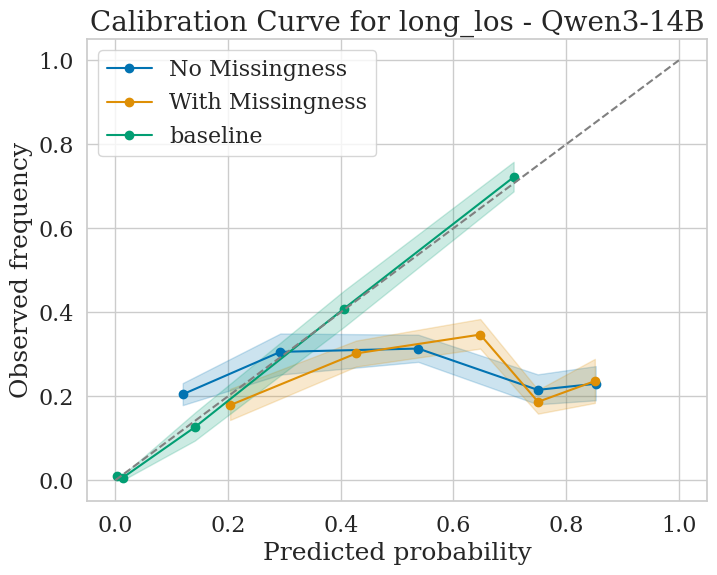

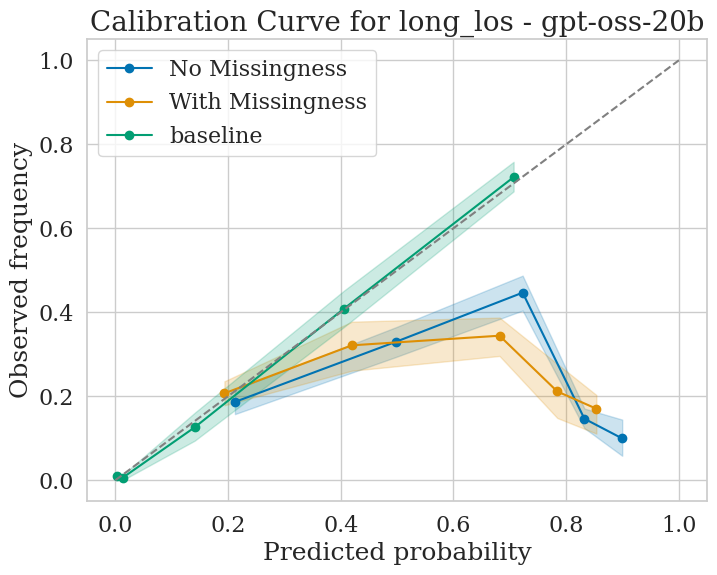

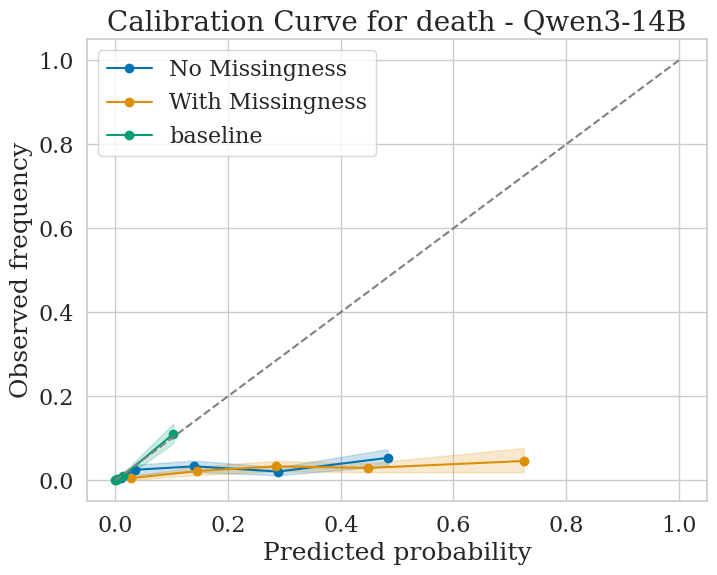

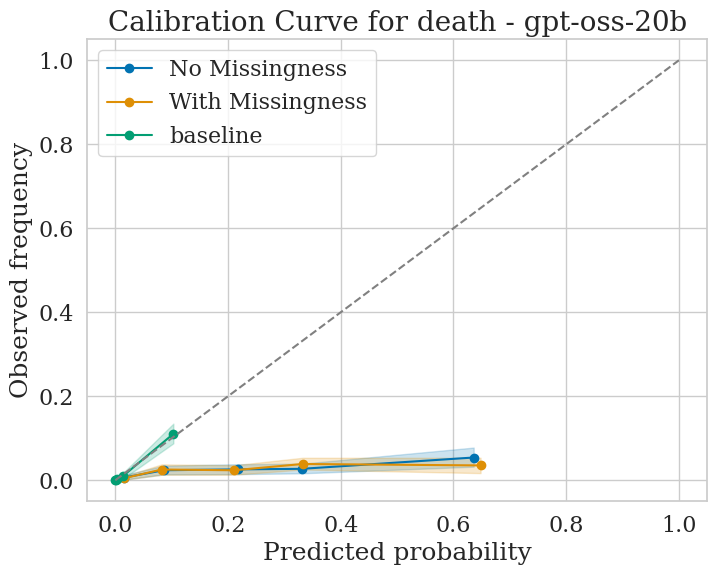

In [6]:
models = ['Qwen3-14B', 'gpt-oss-20b']

for task in tasks:
    # filtered_labels = task_results_dicts[task]['no_missingness']["labels"]
    # label_counts = np.bincount(filtered_labels)
    # total_samples = len(filtered_labels)
    # prevalence = label_counts[1] / total_samples if len(label_counts) > 1 else 0
    # print(f"Label prevalence: {prevalence:.4f} ({label_counts[1] if len(label_counts) > 1 else 0}/{total_samples})")
    # print(f"Label distribution: {dict(zip(range(len(label_counts)), label_counts))}")

    for model in models:
        colors = sns.color_palette("colorblind", 3)
        plt.figure(figsize=(8,6))

        # Calibration curves for each condition
        plt.plot(
            task_metrics[task][f'no_missingness_{model}']['prob_pred_mean'],
            task_metrics[task][f'no_missingness_{model}']['prob_true_mean'],
            marker='o', label='No Missingness', color=colors[0]
        )
        plt.plot(
            task_metrics[task][f'with_missingness_{model}']['prob_pred_mean'],
            task_metrics[task][f'with_missingness_{model}']['prob_true_mean'],
            marker='o', label='With Missingness', color=colors[1]
        )
        plt.plot(
            task_metrics[task][f'baseline']['prob_pred_mean'],
            task_metrics[task][f'baseline']['prob_true_mean'],
            marker='o', label='baseline', color=colors[2]
        )

        # Confidence bands
        plt.fill_between(
            task_metrics[task][f'no_missingness_{model}']['prob_pred_mean'],
            task_metrics[task][f'no_missingness_{model}']['prob_true_lower'],
            task_metrics[task][f'no_missingness_{model}']['prob_true_upper'],
            alpha=0.2, color=colors[0]
        )
        plt.fill_between(
            task_metrics[task][f'with_missingness_{model}']['prob_pred_mean'],
            task_metrics[task][f'with_missingness_{model}']['prob_true_lower'],
            task_metrics[task][f'with_missingness_{model}']['prob_true_upper'],
            alpha=0.2, color=colors[1]
        )
        plt.fill_between(
            task_metrics[task][f'baseline']['prob_pred_mean'],
            task_metrics[task][f'baseline']['prob_true_lower'],
            task_metrics[task][f'baseline']['prob_true_upper'],
            alpha=0.2, color=colors[2]
        )

        # Reference line
        plt.plot([0, 1], [0, 1], '--', color='gray')

        plt.xlabel('Predicted probability')
        plt.ylabel('Observed frequency')
        plt.title(f'Calibration Curve for {task} - {model}')
        plt.legend()

        plt.savefig(f'figures_mlh/calibration_curve_{task}_{model}_{experiment}.pdf',
                    bbox_inches='tight', dpi=300)
        plt.show()

In [7]:
def make_comparison_table_by_task(task_metrics, method_names):
    """
    Create LaTeX table where tasks are super-columns, each with ECE & Log Loss,
    and rows are methods.
    
    task_metrics: dict of {task_name: [results_dict_method1, results_dict_method2, ...]}
    method_names: list of str
    """
    task_names = list(task_metrics.keys())
    n_tasks = len(task_names)
    
    # Column spec: l for methods + 2 columns per task
    col_spec = "l" + "cc" * n_tasks
    
    # Header: first line for tasks
    table = r"\begin{table*}[ht]\centering" + "\n"
    table += r"\caption{Calibration metrics (ECE and Log Loss) with 95\% bootstrap confidence intervals.}" + "\n"
    table += r"\begin{tabular}{" + col_spec + "}\n"
    table += r"\toprule" + "\n"
    
    # Task names as super-columns
    header_tasks = ["Method"]
    for task in task_names:
        header_tasks.append(r"\multicolumn{2}{c}{" + task + "}")
    table += " & ".join(header_tasks) + r" \\" + "\n"
    
    # Sub-columns for ECE and Log Loss
    sub_headers = [""]  # first column empty for method names
    for _ in task_names:
        sub_headers.extend(["ECE", "Log Loss"])
    table += " & ".join(sub_headers) + r" \\" + "\n"
    table += r"\midrule" + "\n"
    
    # Fill rows for each method
    n_methods = len(method_names)
    for i in range(n_methods):
        row = [method_names[i]]
        for task in task_names:
            res = task_metrics[task][method_names[i]]
            ece = f"{res['ece']['mean']:.3f} ({res['ece']['lower']:.3f}, {res['ece']['upper']:.3f})"
            logloss = f"{res['logloss']['mean']:.3f} ({res['logloss']['lower']:.3f}, {res['logloss']['upper']:.3f})"
            row.extend([ece, logloss])
        table += " & ".join(row) + r" \\" + "\n"
    
    table += r"\bottomrule" + "\n"
    table += r"\end{tabular}" + "\n"
    table += r"\label{tab:calibration_comparison}" + "\n"
    table += r"\end{table*}"
    
    return table

columns = []
for model in models:
    columns.append(f"no_missingness_{model}")
    columns.append(f"with_missingness_{model}")
    
columns.append(f"baseline")
columns.append(f"baseline_with_missingness")

latex_table = make_comparison_table_by_task(
    task_metrics,
    columns
)
print(latex_table)

\begin{table*}[ht]\centering
\caption{Calibration metrics (ECE and Log Loss) with 95\% bootstrap confidence intervals.}
\begin{tabular}{lcccc}
\toprule
Method & \multicolumn{2}{c}{long_los} & \multicolumn{2}{c}{death} \\
 & ECE & Log Loss & ECE & Log Loss \\
\midrule
no_missingness_Qwen3-14B & 0.249 (0.232, 0.265) & 0.821 (0.799, 0.842) & 0.144 (0.137, 0.151) & 0.250 (0.236, 0.263) \\
with_missingness_Qwen3-14B & 0.276 (0.261, 0.292) & 0.830 (0.812, 0.849) & 0.243 (0.235, 0.250) & 0.374 (0.362, 0.387) \\
no_missingness_gpt-oss-20b & 0.361 (0.344, 0.378) & 1.040 (1.016, 1.065) & 0.183 (0.176, 0.190) & 0.307 (0.293, 0.322) \\
with_missingness_gpt-oss-20b & 0.323 (0.306, 0.340) & 0.956 (0.934, 0.978) & 0.181 (0.173, 0.189) & 0.309 (0.296, 0.322) \\
baseline & 0.013 (0.006, 0.022) & 0.338 (0.321, 0.356) & 0.003 (0.001, 0.007) & 0.070 (0.060, 0.082) \\
baseline_with_missingness & 0.009 (0.003, 0.018) & 0.310 (0.291, 0.327) & 0.003 (0.001, 0.006) & 0.066 (0.055, 0.078) \\
\bottomrule
\end{ta

In [9]:
task_metrics_weighted= {}

for task in tasks:
    task_metrics_weighted[task] = {}
    task_metrics_weighted[task]['No Missingness Qwen'] = bootstrap_calibration(
        task_results_dicts[task]['no_missingness_Qwen3-14B']["labels"], task_results_dicts[task]['no_missingness_Qwen3-14B']["predictions"], pi=task_results_dicts[task]['pi'])
    task_metrics_weighted[task]['With Missingness Qwen'] = bootstrap_calibration(
        task_results_dicts[task]['with_missingness_Qwen3-14B']["labels"], task_results_dicts[task]['with_missingness_Qwen3-14B']["predictions"], pi=task_results_dicts[task]['pi'])
    task_metrics_weighted[task]['No Missingness GPT'] = bootstrap_calibration(
        task_results_dicts[task]['no_missingness_gpt-oss-20b']["labels"], task_results_dicts[task]['no_missingness_gpt-oss-20b']["predictions"], pi=task_results_dicts[task]['pi'])
    task_metrics_weighted[task]['With Missingness GPT'] = bootstrap_calibration(
        task_results_dicts[task]['with_missingness_gpt-oss-20b']["labels"], task_results_dicts[task]['with_missingness_gpt-oss-20b']["predictions"], pi=task_results_dicts[task]['pi'])
    task_metrics_weighted[task]['Baseline'] = bootstrap_calibration(
        task_results_dicts[task]['baseline']["labels"], task_results_dicts[task]['baseline']["predictions"])
    task_metrics_weighted[task]['Baseline with Missingness'] = bootstrap_calibration(
        task_results_dicts[task]['baseline_with_missingness']["labels"], task_results_dicts[task]['baseline_with_missingness']["predictions"])

In [10]:
latex_table = make_comparison_table_by_task(
    task_metrics_weighted,
    ["No Missingness Qwen", "With Missingness Qwen", "No Missingness GPT", "With Missingness GPT", "Baseline", "Baseline with Missingness"]
)
print(latex_table)

\begin{table*}[ht]\centering
\caption{Calibration metrics (ECE and Log Loss) with 95\% bootstrap confidence intervals.}
\begin{tabular}{lcccc}
\toprule
Method & \multicolumn{2}{c}{long_los} & \multicolumn{2}{c}{in_hospital_mortality} \\
 & ECE & Log Loss & ECE & Log Loss \\
\midrule
No Missingness Qwen & 0.098 (0.082, 0.114) & 0.662 (0.645, 0.680) & 0.051 (0.046, 0.055) & 0.125 (0.119, 0.131) \\
With Missingness Qwen & 0.084 (0.069, 0.101) & 0.654 (0.642, 0.668) & 0.119 (0.113, 0.125) & 0.191 (0.183, 0.199) \\
No Missingness GPT & 0.123 (0.107, 0.139) & 0.688 (0.668, 0.707) & 0.067 (0.062, 0.072) & 0.138 (0.131, 0.146) \\
With Missingness GPT & 0.101 (0.085, 0.118) & 0.656 (0.638, 0.675) & 0.070 (0.065, 0.075) & 0.141 (0.133, 0.148) \\
Baseline & 0.028 (0.013, 0.045) & 0.639 (0.629, 0.649) & 0.035 (0.023, 0.047) & 0.463 (0.444, 0.481) \\
Baseline with Missingness & 0.021 (0.008, 0.035) & 0.600 (0.586, 0.613) & 0.020 (0.011, 0.031) & 0.400 (0.381, 0.419) \\
\bottomrule
\end{tabular}
\la

In [9]:
task_metrics_subgroup = {}
for task in tasks:

    missing_counts = np.array(task_results_dicts[task]['baseline_with_missingness']["missing_counts"])
    mask = missing_counts > 1

    task_results_dicts_subgroup = {}

    for method in ['no_missingness', 'with_missingness', 'baseline', 'baseline_with_missingness']:
        task_results_dicts_subgroup[method] = {}
        task_results_dicts_subgroup[method]["labels"] = np.array(task_results_dicts[task][method]["labels"])[mask]
        task_results_dicts_subgroup[method]["predictions"] = np.array(task_results_dicts[task][method]["predictions"])[mask]

    # Calculate number of missing features per patient
    task_metrics_subgroup[task] = {}
    task_metrics_subgroup[task]['No Missingness'] = bootstrap_calibration(
        task_results_dicts_subgroup['no_missingness']["labels"], task_results_dicts_subgroup['no_missingness']["predictions"], n_bootstrap, n_bins)
    task_metrics_subgroup[task]['With Missingness'] = bootstrap_calibration(
        task_results_dicts_subgroup['with_missingness']["labels"], task_results_dicts_subgroup['with_missingness']["predictions"], n_bootstrap, n_bins)
    task_metrics_subgroup[task]['Baseline'] = bootstrap_calibration(
        task_results_dicts_subgroup['baseline']["labels"], task_results_dicts_subgroup['baseline']["predictions"], n_bootstrap, n_bins)
    task_metrics_subgroup[task]['Baseline with Missingness'] = bootstrap_calibration(
        task_results_dicts_subgroup['baseline_with_missingness']["labels"], task_results_dicts_subgroup['baseline_with_missingness']["predictions"], n_bootstrap, n_bins)

/tmp/ipykernel_1609938/2520138568.py:60: RuntimeWarning: Mean of empty slice
  prob_true_mean = np.nanmean(prob_true_bootstrap, axis=0)
/data/anaconda3/envs/afa_env/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/tmp/ipykernel_1609938/2520138568.py:63: RuntimeWarning: Mean of empty slice
  prob_pred_mean = np.nanmean(prob_pred_bootstrap, axis=0)
/tmp/ipykernel_1609938/2520138568.py:60: RuntimeWarning: Mean of empty slice
  prob_true_mean = np.nanmean(prob_true_bootstrap, axis=0)
/data/anaconda3/envs/afa_env/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/tmp/ipykernel_1609938/2520138568.py:63: RuntimeWarning: Mean of empty slice
  prob_pred_mean = np.nanmean(prob_pred_bootstrap, axis=0)


No Missingness Log Loss: 0.4445
With Missingness Log Loss: 0.4708
ECE (No Missingness): 0.0717
ECE (With Missingness): 0.0679


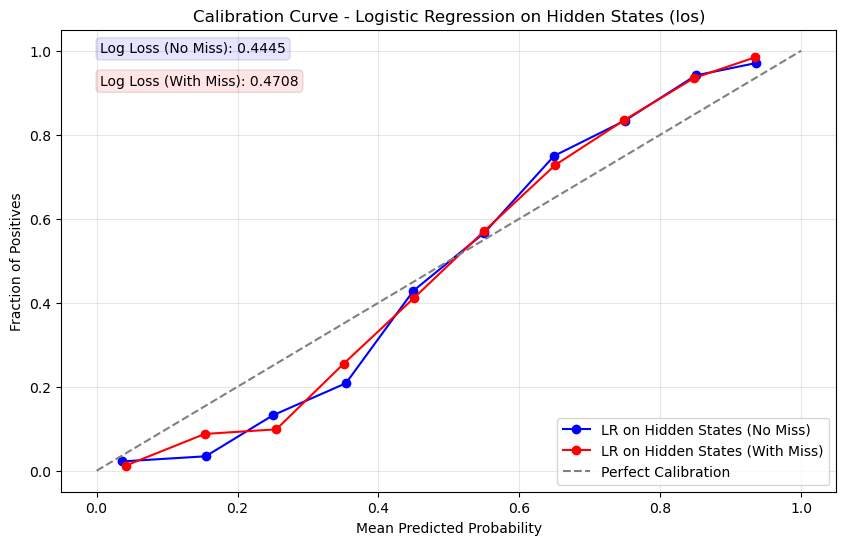

In [17]:
# Fit logistic regression to predict labels using hidden states
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve

# Fit logistic regression model
# Concatenate hidden states and labels from both models
concatenated_hiddens = np.concatenate([filtered_hiddens_1, filtered_hiddens_2], axis=0)
concatenated_labels = np.concatenate([filtered_labels, filtered_labels], axis=0)

lr_model = LogisticRegression(random_state=42, C=0.3, max_iter=5000)
lr_model.fit(concatenated_hiddens, concatenated_labels)

# Get predictions for each model's hidden states
lr_probabilities1 = lr_model.predict_proba(filtered_hiddens_1)[:, 1]
lr_log_loss1 = log_loss(filtered_labels, lr_probabilities1)
print(f"No Missingness Log Loss: {lr_log_loss1:.4f}")

lr_probabilities2 = lr_model.predict_proba(filtered_hiddens_2)[:, 1]
lr_log_loss2 = log_loss(filtered_labels, lr_probabilities2)
print(f"With Missingness Log Loss: {lr_log_loss2:.4f}")

# Calculate calibration for both models
prob_true_lr1, prob_pred_lr1 = calibration_curve(filtered_labels, lr_probabilities1, n_bins=10)
prob_true_lr2, prob_pred_lr2 = calibration_curve(filtered_labels, lr_probabilities2, n_bins=10)

# Compute Expected Calibration Error (ECE)
def compute_ece(y_true, y_prob, n_bins=10):
    y_true = np.array(y_true)   # ensure numpy arrays
    y_prob = np.array(y_prob)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    
    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        
        # Put sample in bin if bin_lower <= prob < bin_upper
        in_bin = (y_prob >= bin_lower) & (y_prob < bin_upper)
        # For the last bin, include right edge (==1.0)
        if i == n_bins - 1:
            in_bin = (y_prob >= bin_lower) & (y_prob <= bin_upper)
        
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece


ece_lr1 = compute_ece(filtered_labels, lr_probabilities1)
ece_lr2 = compute_ece(filtered_labels, lr_probabilities2)

print(f"ECE (No Missingness): {ece_lr1:.4f}")
print(f"ECE (With Missingness): {ece_lr2:.4f}")

# Create calibration plot
plt.figure(figsize=(10, 6))
plt.plot(prob_pred_lr1, prob_true_lr1, marker='o', label='LR on Hidden States (No Miss)', color='blue')
plt.plot(prob_pred_lr2, prob_true_lr2, marker='o', label='LR on Hidden States (With Miss)', color='red')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve - Logistic Regression on Hidden States ({task})')
plt.text(0.05, 0.95, f'Log Loss (No Miss): {lr_log_loss1:.4f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='blue', alpha=0.1))
plt.text(0.05, 0.88, f'Log Loss (With Miss): {lr_log_loss2:.4f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='red', alpha=0.1))
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'plots/calibration_lr_hidden_states_{config["downstream_task"]}_{model_name}.png')
plt.show()


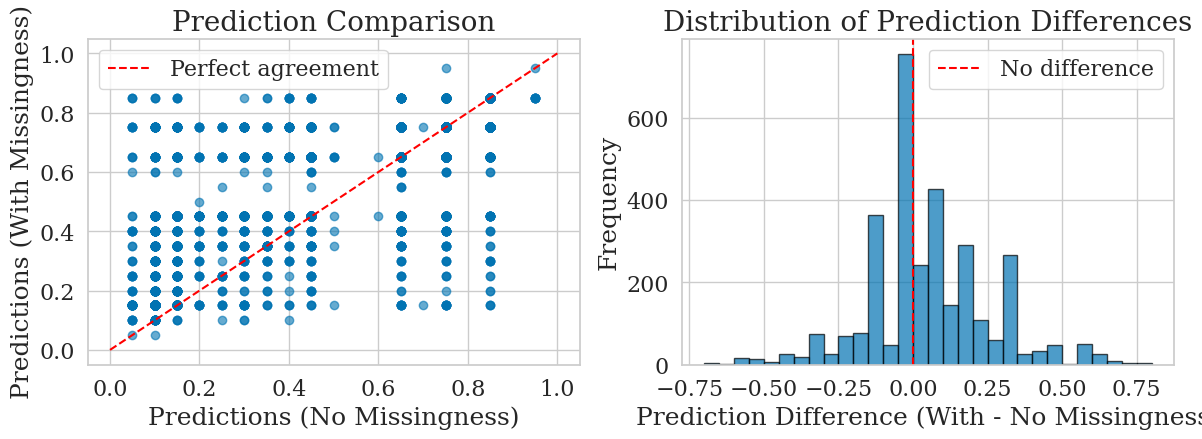


Prediction Difference Statistics:
Mean difference: 0.073177
Std difference: 0.205883


In [9]:
import pandas as pd

task = 'long_los'
model = 'Qwen3-14B'
#models = ['Qwen3-14B', 'gpt-oss-20b']
# task = 'in_hospital_mortality'

# Plot individual differences
plt.figure(figsize=(12, 8))

# Subplot 1: Scatter plot of predictions
plt.subplot(2, 2, 1)
plt.scatter(task_results_dicts[task][f'no_missingness_{model}']['predictions'], task_results_dicts[task][f'with_missingness_{model}']['predictions'], alpha=0.6)
plt.plot([0, 1], [0, 1], '--', color='red', label='Perfect agreement')
plt.xlabel('Predictions (No Missingness)')
plt.ylabel('Predictions (With Missingness)')
plt.title('Prediction Comparison')
plt.legend()

pred_with = np.array(task_results_dicts[task][f'with_missingness_{model}']['predictions'])
pred_no   = np.array(task_results_dicts[task][f'no_missingness_{model}']['predictions'])

differences = pred_with - pred_no

# Subplot 2: Histogram of differences
plt.subplot(2, 2, 2)
plt.hist(differences, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Difference (With - No Missingness)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Differences')
plt.axvline(x=0, color='red', linestyle='--', label='No difference')
plt.legend()

plt.tight_layout()
plt.savefig(f'figures_mlh/prediction_comparison_{config["downstream_task"]}_{model_name}.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\nPrediction Difference Statistics:")
print(f"Mean difference: {differences.mean():.6f}")
print(f"Std difference: {differences.std():.6f}")


In [11]:
losses_with = np.array(task_results_dicts[task][f'with_missingness_{model}']['log_losses'])
losses_no   = np.array(task_results_dicts[task][f'no_missingness_{model}']['log_losses'])

# Find cases with largest positive differences (where with_missing > no_missing)
# k = 5
# top_positive_diff = np.argsort(differences)[-k:][::-1]
differences = losses_with - losses_no  

# Only keep indices where no_missingness is better
better_mask = differences > 0  

# Get sorted indices of largest differences
sorted_indices = np.argsort(differences[better_mask])[::-1]

# Map back to original indices
better_indices = np.where(better_mask)[0][sorted_indices]

# Top-k
k = 5
top_positive_diff = better_indices[:k]

print(top_positive_diff)

print("Top 10 cases with largest positive differences (with_missing > no_missing):")
print("=" * 80)

print(len(task_results_dicts[task][f'no_missingness_{model}']['serializations']))

for idx in top_positive_diff:
    print("label: ", task_results_dicts[task][f'no_missingness_{model}']['labels'][idx])
    serialization1 = task_results_dicts[task][f'no_missingness_{model}']['serializations'][idx]
    response1 = task_results_dicts[task][f'no_missingness_{model}']['responses'][idx]
    loss1 = task_results_dicts[task][f'no_missingness_{model}']['log_losses'][idx]
    print(f"Loss: {loss1}")
    # Get the serialization and response for this subject
    print(f"\nSerialization (No Missingness):")
    print(serialization1)
    print(f"\nResponse (No Missingness):")
    print(response1)
    
    serialization2 = task_results_dicts[task][f'with_missingness_{model}']['serializations'][idx]
    response2 = task_results_dicts[task][f'with_missingness_{model}']['responses'][idx]
    
    loss2 = task_results_dicts[task][f'with_missingness_{model}']['log_losses'][idx]
    print(f"Loss: {loss2}")

    print(f"\nSerialization (With Missingness):")
    print(serialization2)
    print(f"\nResponse (With Missingness):")
    print(response2)
    
    print("=" * 80)



[ 164 2630 1916 1046 1044]
Top 10 cases with largest positive differences (with_missing > no_missing):
3236
label:  False
Loss: 0.05129329438649797

Serialization (No Missingness):

 # Electronic Health Record (Observation Window: 30 days)
## Prediction Time: 2017-08-23
## Demographics
Patient age: 23
Patient gender: female
Patient race: unknown
## Most Recent Measurements
- Body Weight
  - 2398.63 (unit: UCUM/[oz_av]) measured at 2017-08-22
- Heart Rate
  - 84.0 (unit: UCUM//min) measured at 2017-08-23
- Systolic blood pressure
  - 117.0 (unit: UCUM/mm[Hg]) measured at 2017-08-23
- Diastolic blood pressure
  - 78.0 (unit: UCUM/mm[Hg]) measured at 2017-08-23
- Respiratory rate
  - 18.0 (unit: UCUM//min) measured at 2017-08-23
- Oxygen saturation
  - 24.4 (unit: UCUM/%) measured at 2017-08-22
- Hemoglobin
  - 9.5 (unit: UCUM/g/dL) measured at 2017-08-23
- Hematocrit
  - 28.1 (unit: UCUM/%) measured at 2017-08-23
- Erythrocytes
  - 3.24 (unit: UCUM/10*12/L) measured at 2017-08-23
- Leuko

Models
- Small and large
- Finetuned to medical vs not

Serialization
- No missing
- Missing

Prompting
- Reason about missingness

Tasks
- Lab only 
- Lab + Context